In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore')

In [2]:
def load_and_merge_data(afternoon_path, evening_path):
    """Load and merge data from CSV files."""
    afternoon_df = pd.read_csv(afternoon_path)
    evening_df = pd.read_csv(evening_path)
    return pd.concat([afternoon_df, evening_df], ignore_index=True)

In [3]:
def feature_engineering(df):
    """Perform feature engineering."""
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['TimeInSeconds'] = df['Timestamp'].dt.hour * 3600 + \
                          df['Timestamp'].dt.minute * 60 + \
                          df['Timestamp'].dt.second
    return df.drop(columns=["ReadingID", "Timestamp"])


In [4]:
# Loading and preprocessing data
sensor_data = load_and_merge_data('/content/drive/MyDrive/IoT_Data/afternoon_sensorreadings.csv', '/content/drive/MyDrive/IoT_Data/evening_sensorreadings.csv')
processed_data = feature_engineering(sensor_data)

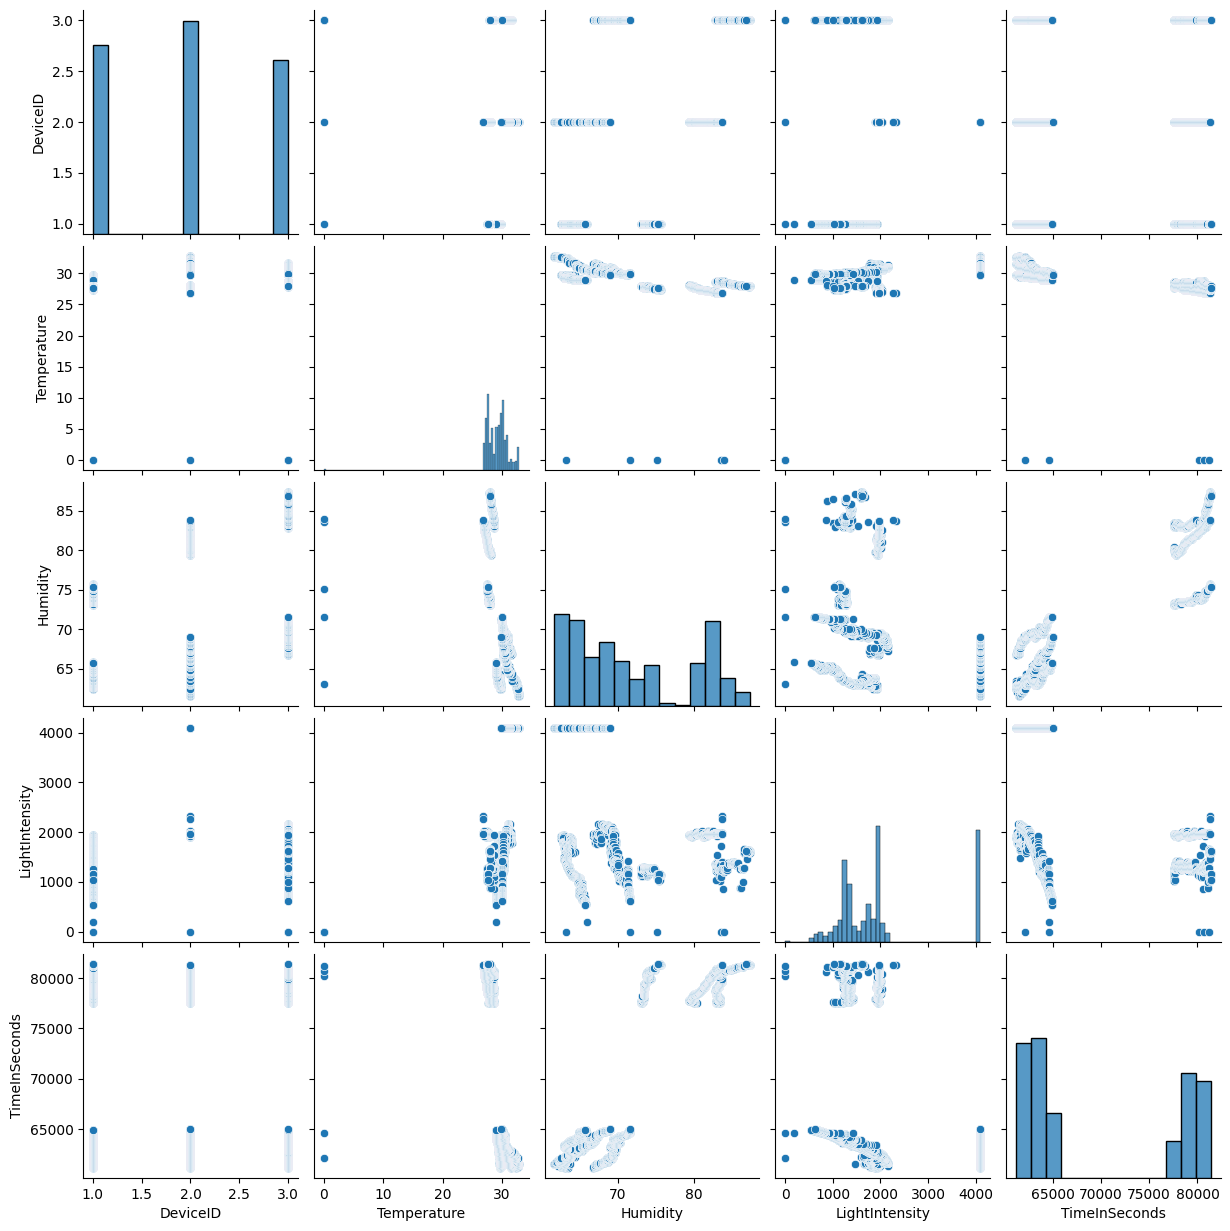

In [5]:
# Assuming 'processed_data' is your DataFrame
sns.pairplot(processed_data)
plt.show()

In [6]:
processed_data.head()
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2707 entries, 0 to 2706
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DeviceID        2707 non-null   int64  
 1   Temperature     2707 non-null   float64
 2   Humidity        2707 non-null   float64
 3   LightIntensity  2707 non-null   int64  
 4   TimeInSeconds   2707 non-null   int32  
dtypes: float64(2), int32(1), int64(2)
memory usage: 95.3 KB


In [7]:
def normalize_features(X):
    """Normalize features using Min-Max Scaling."""
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(X), columns=X.columns), scaler

In [8]:
def plot_feature_correlation(df):
    """Visualize feature correlations."""
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()

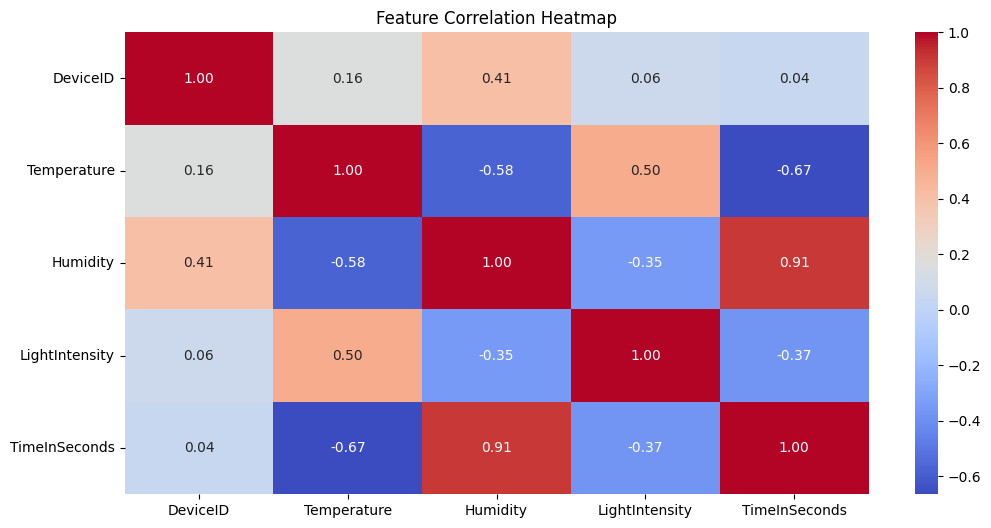

In [9]:
# Feature correlation plot
plot_feature_correlation(processed_data)

The correlation heatmap reveals key relationships among features. DeviceID shows negligible correlation with other variables, acting primarily as an identifier of the Device Location. Temperature is negatively correlated with Humidity (-0.58) and TimeInSeconds (-0.67), but positively with LightIntensity (0.50). Humidity strongly correlates with TimeInSeconds (0.91) and negatively with LightIntensity (-0.35). LightIntensity moderately correlates with Temperature (0.50) but has weak links to other features. TimeInSeconds strongly correlates with Humidity (0.91) and negatively with Temperature (-0.67). Overall, Humidity and TimeInSeconds have the strongest relationship, while DeviceID has minimal influence on other variables.

In [10]:
# Define features (X) and target (y)
X = processed_data.drop(columns=["Temperature"])
y = processed_data["Temperature"]

# Normalize features
X_normalized, scaler = normalize_features(X)

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [12]:

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    """Train various machine learning models and select the best one based on MAE."""
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Support Vector Regression': SVR(kernel='rbf')
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)  # Calculate MAE
        results[name] = mae
        print(f"{name}: MAE = {mae:.4f}")

    # Select the model with the lowest MAE
    best_model_name = min(results, key=results.get)
    print(f"\nBest Model: {best_model_name} with MAE = {results[best_model_name]:.4f}")

    return models[best_model_name]


In [13]:
# Train and evaluate machine learning models
best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)

Linear Regression: MAE = 0.3211
Random Forest: MAE = 0.0550
Support Vector Regression: MAE = 0.1303

Best Model: Random Forest with MAE = 0.0550


In [14]:
def convert_time_to_seconds(time_input):
    # Split the input by the colon (:) to get hours, minutes, and seconds
    hours, minutes, seconds = map(int, time_input.split(":"))

    # Calculate total seconds
    total_seconds = (hours * 3600) + (minutes * 60) + seconds
    return total_seconds

In [15]:
y.head(100)

,Temperature
0,32.4
1,31.5
2,29.7
3,32.5
4,29.7
...,...
95,31.2
96,29.6
97,32.8
98,31.1


In [16]:
# Predicting the 100th entry data
entry_100 = X_normalized.iloc[99].values.reshape(1, -1)
predicted_temperature = best_model.predict(entry_100)[0]

# Print the results
print(f"Predicted Temperature for the 100th entry: {predicted_temperature}")

Predicted Temperature for the 100th entry: 29.65999999999995


In [17]:
def build_and_train_neural_network(X_train, y_train):
    """Build, train, and evaluate a neural network."""
    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Add Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=1000,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping]
    )

    return model, history

In [18]:
# Build and train neural network
nn_model, nn_history = build_and_train_neural_network(X_train.values, y_train.values)

Epoch 1/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 818.6694 - mae: 28.5256 - val_loss: 669.6262 - val_mae: 25.7598
Epoch 2/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 566.1337 - mae: 23.4838 - val_loss: 199.1955 - val_mae: 12.8480
Epoch 3/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135.0528 - mae: 10.0739 - val_loss: 73.3100 - val_mae: 7.1210
Epoch 4/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.5158 - mae: 6.5749 - val_loss: 51.5632 - val_mae: 5.9005
Epoch 5/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 44.5271 - mae: 5.5447 - val_loss: 35.0122 - val_mae: 4.9195
Epoch 6/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.9048 - mae: 4.5436 - val_loss: 23.8705 - val_mae: 4.1883
Epoch 7/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.6974 - mae: 3.9485 - val_loss: 16.2887 - val_mae: 3.4490
Epoch 8/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.3535 - mae: 3.1930 - val_loss: 11.3213 - val_mae: 2.7413
Epoch 9/1000
55/55 ━━━━━━━━━━━

In [19]:
def plot_training_history(history):
    """Plot training history for the neural network with improved aesthetics."""
    plt.figure(figsize=(14, 7))

    # Colors for training and validation
    train_color = 'green'
    val_color = 'red'

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color=train_color, marker='o', markersize=5, linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color=val_color, marker='o', markersize=5, linewidth=2)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.title('Loss over Epochs', fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # MAE Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE', color=train_color, marker='o', markersize=5, linewidth=2)
    plt.plot(history.history['val_mae'], label='Validation MAE', color=val_color, marker='o', markersize=5, linewidth=2)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
    plt.title('MAE over Epochs', fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

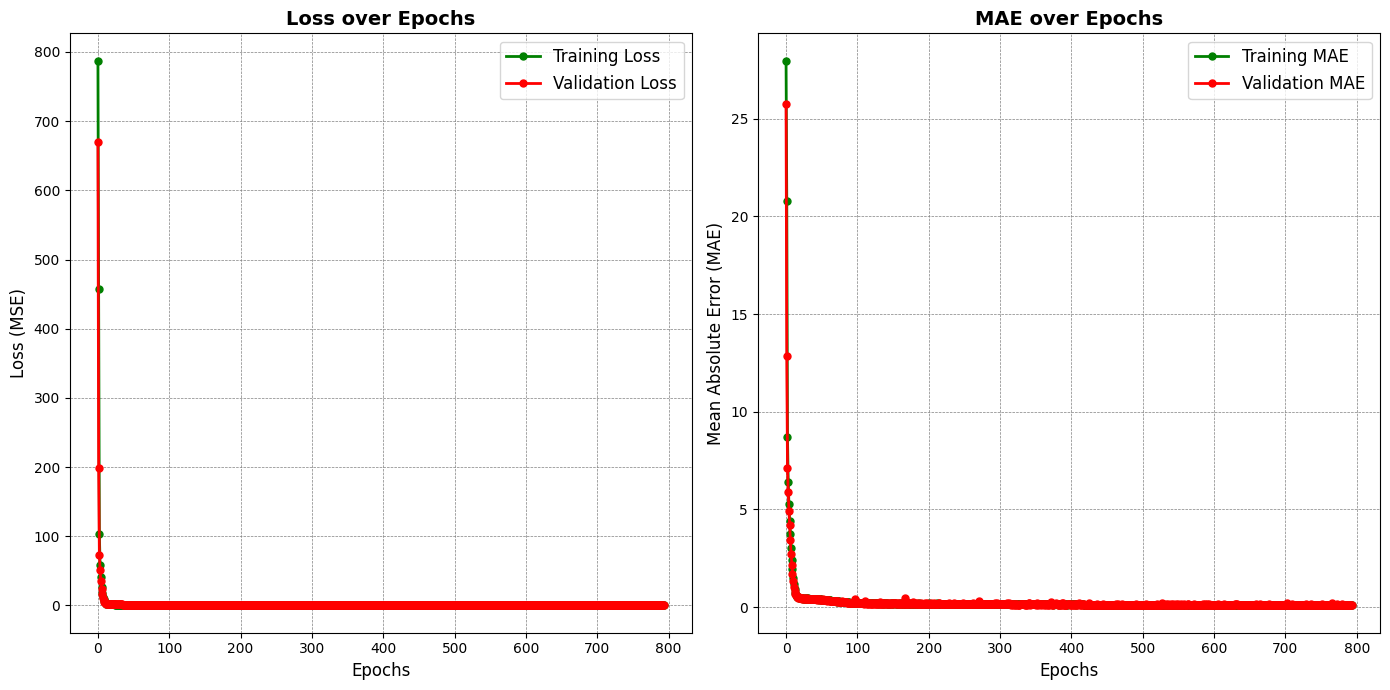

In [20]:
# Plot training history for neural network
plot_training_history(nn_history)

In [21]:
# Evaluate the neural network on the test set
nn_test_loss, nn_test_mae = nn_model.evaluate(X_test.values, y_test.values, verbose=0)
print(f"\nNeural Network Test Loss: {nn_test_loss:.4f}")
print(f"Neural Network Test MAE: {nn_test_mae:.4f}")


Neural Network Test Loss: 0.0738
Neural Network Test MAE: 0.0925


Saving the Random Forest model as it is the best permoming model with a MAE of 0.0550 compared to that of the neural network which is 0.0925


In [22]:
import pickle
from sklearn.linear_model import LinearRegression

def save_model_and_scaler(model, scaler, model_filename, scaler_filename):
    """
    Save the given model and scaler to specified file paths.

    Args:
    - model: The machine learning model to save.
    - scaler: The scaler object used for preprocessing.
    - model_filename (str): Path to save the model file.
    - scaler_filename (str): Path to save the scaler file.
    """
    # Save the model
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model, model_file)
    print(f"Model saved successfully as {model_filename}")

    # Save the scaler
    with open(scaler_filename, 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)
    print(f"Scaler saved successfully as {scaler_filename}")


In [23]:
if isinstance(best_model, RandomForestRegressor):
    save_model_and_scaler(
        best_model,
        scaler,
        "/content/drive/MyDrive/IoT_Data/best_random_forest_model.pkl",
        "/content/drive/MyDrive/IoT_Data/scaler.pkl"
    )

Model saved successfully as /content/drive/MyDrive/IoT_Data/best_random_forest_model.pkl
Scaler saved successfully as /content/drive/MyDrive/IoT_Data/scaler.pkl


Loading the saved model for testing

In [24]:
import pickle

# Load the pickle model
with open('/content/drive/MyDrive/IoT_Data/best_random_forest_model.pkl', 'rb') as f:
    pred_model = pickle.load(f)

# Load the scaler
with open('/content/drive/MyDrive/IoT_Data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print("Pickle model and Scaler successfully loaded!")

Pickle model and Scaler successfully loaded!


In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# User input for the entry
device_id = int(input("Enter Device ID: "))
humidity = float(input("Enter Humidity: "))
light_intensity = int(input("Enter Light Intensity: "))
time_input = input("Enter time in HH:MM:SS format (e.g., 16:24:34): ")

time_in_seconds = convert_time_to_seconds(time_input)


# Create a DataFrame with the single entry
entry = pd.DataFrame({"DeviceID": [device_id], "Humidity": [humidity], "LightIntensity": [light_intensity], "TimeInSeconds": [time_in_seconds]})
entry_scaled = pd.DataFrame(scaler.transform(entry), columns=entry.columns)

# Predict the temperature
predicted_temperature = pred_model.predict(entry_scaled)[0]

print(f"Predicted Temperature for the entered entry: {predicted_temperature}")

Enter Device ID: 2
Enter Humidity: 83.7
Enter Light Intensity: 1966
Enter time in HH:MM:SS format (e.g., 16:24:34): 10:34:25
Predicted Temperature for the entered entry: 28.36600000000003
